In [1]:
import tensorflow as tf

class siamese:

    # Create model
    def __init__(self):
        self.x1 = tf.placeholder(tf.float32, [None, 784])
        self.x2 = tf.placeholder(tf.float32, [None, 784])

        with tf.variable_scope("siamese") as scope:
            self.o1 = self.network(self.x1)
            scope.reuse_variables()
            self.o2 = self.network(self.x2)

        # Create loss
        self.y_ = tf.placeholder(tf.float32, [None])
        self.loss = self.loss_with_spring()

    def network(self, x):
        weights = []
        fc1 = self.fc_layer(x, 1024, "fc1")
        ac1 = tf.nn.relu(fc1)
        fc2 = self.fc_layer(ac1, 1024, "fc2")
        ac2 = tf.nn.relu(fc2)
        fc3 = self.fc_layer(ac2, 2, "fc3")
        return fc3

    def fc_layer(self, bottom, n_weight, name):
        assert len(bottom.get_shape()) == 2
        n_prev_weight = bottom.get_shape()[1]
        initer = tf.truncated_normal_initializer(stddev=0.01)
        W = tf.get_variable(name+'W', dtype=tf.float32, shape=[n_prev_weight, n_weight], initializer=initer)
        b = tf.get_variable(name+'b', dtype=tf.float32, initializer=tf.constant(0.01, shape=[n_weight], dtype=tf.float32))
        fc = tf.nn.bias_add(tf.matmul(bottom, W), b)
        return fc

    def loss_with_spring(self):
        margin = 5.0
        labels_t = self.y_
        labels_f = tf.subtract(1.0, self.y_, name="1-yi")          # labels_ = !labels;
        eucd2 = tf.pow(tf.subtract(self.o1, self.o2), 2)
        eucd2 = tf.reduce_sum(eucd2, 1)
        eucd = tf.sqrt(eucd2+1e-6, name="eucd")
        C = tf.constant(margin, name="C")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = tf.multiply(labels_t, eucd2, name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = tf.multiply(labels_f, tf.pow(tf.maximum(tf.subtract(C, eucd), 0), 2), name="Nyi_x_C-eucd_xx_2")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss

    def loss_with_step(self):
        margin = 5.0
        labels_t = self.y_
        labels_f = tf.subtract(1.0, self.y_, name="1-yi")          # labels_ = !labels;
        eucd2 = tf.pow(tf.subtract(self.o1, self.o2), 2)
        eucd2 = tf.reduce_sum(eucd2, 1)
        eucd = tf.sqrt(eucd2+1e-6, name="eucd")
        C = tf.constant(margin, name="C")
        pos = tf.multiply(labels_t, eucd, name="y_x_eucd")
        neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C, eucd)), name="Ny_C-eucd")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss

/Users/dweepa/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from builtins import input

#import system things
from tensorflow.examples.tutorials.mnist import input_data # for data
import tensorflow as tf
import numpy as np
import os

# prepare data and tf.session
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)
sess = tf.InteractiveSession()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# setup siamese network
siam = siamese();
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(siam.loss)
saver = tf.train.Saver()
tf.initialize_all_variables().run()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [4]:

# if you just want to load a previously trainmodel?
load = False
model_ckpt = './model.meta'
if os.path.isfile(model_ckpt):
    input_var = None
    while input_var not in ['yes', 'no']:
        input_var = input("We found model files. Do you want to load it and continue training [yes/no]?")
    if input_var == 'yes':
        load = True

In [7]:
# start training
if load: saver.restore(sess, './model')

for step in range(50000):
    batch_x1, batch_y1 = mnist.train.next_batch(128)
    batch_x2, batch_y2 = mnist.train.next_batch(128)
    #batch_x2, batch_y2 = mnist.train.next_batch(128)
    batch_y = (batch_y1 == batch_y2).astype('float')

    _, loss_v = sess.run([train_step, siam.loss], feed_dict={
                        siam.x1: batch_x1,
                        siam.x2: batch_x2,
                        siam.y_: batch_y})

    if np.isnan(loss_v):
        print('Model diverged with loss = NaN')
        quit()

    if step % 10 == 0:
        print ('step %d: loss %.3f' % (step, loss_v))

    if step % 1000 == 0 and step > 0:
        saver.save(sess, './model')
        embed = siam.o1.eval({siam.x1: mnist.test.images})
        embed.tofile('embed.txt')

step 0: loss 2.701
step 10: loss 2.363
step 20: loss 1.912
step 30: loss 1.145
step 40: loss 2.178
step 50: loss 2.497
step 60: loss 1.630
step 70: loss 1.739
step 80: loss 1.748
step 90: loss 1.293
step 100: loss 1.772
step 110: loss 1.436
step 120: loss 2.064
step 130: loss 2.389
step 140: loss 1.076
step 150: loss 1.899
step 160: loss 1.323
step 170: loss 2.006
step 180: loss 1.041
step 190: loss 3.615
step 200: loss 1.275
step 210: loss 2.220
step 220: loss 1.675
step 230: loss 1.643
step 240: loss 1.367
step 250: loss 1.884
step 260: loss 2.075
step 270: loss 1.171
step 280: loss 0.997
step 290: loss 1.621
step 300: loss 1.604
step 310: loss 1.645
step 320: loss 1.777
step 330: loss 1.478
step 340: loss 2.843
step 350: loss 2.207
step 360: loss 1.546
step 370: loss 1.244
step 380: loss 1.034
step 390: loss 1.977
step 400: loss 2.159
step 410: loss 2.019
step 420: loss 2.625
step 430: loss 1.191
step 440: loss 1.382
step 450: loss 1.528
step 460: loss 0.921
step 470: loss 1.197
ste

KeyboardInterrupt: 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


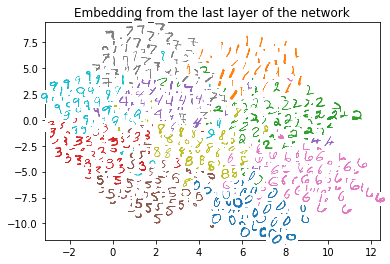

In [8]:
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox


def visualize(embed, x_test, y_test):

    # two ways of visualization: scale to fit [0,1] scale
    # feat = embed - np.min(embed, 0)
    # feat /= np.max(feat, 0)

    # two ways of visualization: leave with original scale
    feat = embed
    ax_min = np.min(embed,0)
    ax_max = np.max(embed,0)
    ax_dist_sq = np.sum((ax_max-ax_min)**2)

    plt.figure()
    ax = plt.subplot(111)
    colormap = plt.get_cmap('tab10')
    shown_images = np.array([[1., 1.]])
    for i in range(feat.shape[0]):
        dist = np.sum((feat[i] - shown_images)**2, 1)
        if np.min(dist) < 3e-4*ax_dist_sq:   # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [feat[i]]]
        patch_to_color = np.expand_dims(x_test[i], -1)
        patch_to_color = np.tile(patch_to_color, (1, 1, 3))
        patch_to_color = (1-patch_to_color) * (1,1,1) + patch_to_color * colormap(y_test[i]/10.)[:3]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(patch_to_color, zoom=0.5, cmap=plt.cm.gray_r),
            xy=feat[i], frameon=False
        )
        ax.add_artist(imagebox)

    plt.axis([ax_min[0], ax_max[0], ax_min[1], ax_max[1]])
    # plt.xticks([]), plt.yticks([])
    plt.title('Embedding from the last layer of the network')
    plt.show()

if __name__ == "__main__":

    mnist = input_data.read_data_sets('MNIST_data', one_hot=False)
    x_test = mnist.test.images
    y_test = mnist.test.labels
    x_test = x_test.reshape([-1, 28, 28])

    embed = np.fromfile('embed.txt', dtype=np.float32)
    embed = embed.reshape([-1, 2])

    visualize(embed, x_test, y_test)

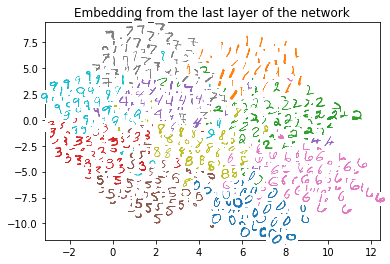

In [9]:
x_test = mnist.test.images.reshape([-1, 28, 28])
y_test = mnist.test.labels
visualize(embed, x_test, y_test)